# Setup

In [1]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn import preprocessing

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last'

In [2]:
# setting some visualization parameters
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
def load_preprocess_df():
    df = pd.read_csv('stroke_det_cat.csv')
    cats = list(df.select_dtypes(include=['object', 'category']).columns)
    nums = list(df.select_dtypes(exclude=['object', 'category']).columns)
    
    features_to_conv = ['bmi_range', 'hypertension', 'heart_disease', 'stroke']
    cats.extend(features_to_conv)
    for feature in features_to_conv:
        if feature in nums:
            nums.remove(feature)
    print(f'Categorical variables:  {cats}')
    print(f'Numerical variables:  {nums}')
    df = df.astype({i: 'category' for i in cats})
    df = pd.concat([df[cats], df[nums]], axis=1)
    return df

In [4]:
df = load_preprocess_df()
df.head()

Categorical variables:  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_range', 'hypertension', 'heart_disease', 'stroke']
Numerical variables:  ['age', 'avg_glucose_level', 'bmi']


,gender,ever_married,work_type,Residence_type,smoking_status,bmi_range,hypertension,heart_disease,stroke,age,avg_glucose_level,bmi
0,Male,Yes,Private,Urban,formerly smoked,3,0,1,1,67.0,228.69,36.6
1,Female,Yes,Self-employed,Rural,never smoked,2,0,0,1,61.0,202.21,28.1
2,Male,Yes,Private,Rural,never smoked,3,0,1,1,80.0,105.92,32.5
3,Female,Yes,Private,Urban,smokes,3,0,0,1,49.0,171.23,34.4
4,Female,Yes,Self-employed,Rural,never smoked,1,1,0,1,79.0,174.12,24.0


In [5]:
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_range', 'hypertension', 'heart_disease', 'stroke']
num_features = ['age', 'avg_glucose_level', 'bmi']

In [6]:
# Setting significance level as 0.05
ALPHA = 0.05

# Statistical Analysis on Categorical Features

**Hypothesis definition** <br>
Null hypothesis, $H_0$ : Variable A and Variable B are **independent** <br>
Alternative hypothesis, $H_1$ : Variable A and Variable B are **dependent** <br>
 <br>
Significance level, $\alpha$ is generally set to 0.05. <br>

- p-value $\le$  $\alpha$ : significant result, reject null hypothesis.
- p-value $\gt$  $\alpha$ : not significant result, fail to reject null hypothesis. <br><br>
- To analyze whether there is a significant association between two categorical features, **Pearson's chi-squared test** analysis is commonly used.

In [7]:
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import LabelEncoder

In [8]:
df_cat_label =  pd.concat([df.loc[:, 'gender': 'smoking_status'].apply(lambda x: LabelEncoder().fit_transform(x)),
                           df.loc[:, 'bmi_range': 'stroke']], axis=1)

df_cat_label.head()

,gender,ever_married,work_type,Residence_type,smoking_status,bmi_range,hypertension,heart_disease,stroke
0,1,1,2,1,1,3,0,1,1
1,0,1,3,0,2,2,0,0,1
2,1,1,2,0,2,3,0,1,1
3,0,1,2,1,3,3,0,0,1
4,0,1,3,0,2,1,1,0,1


In [9]:
chi2_res = chi2(df_cat_label, df.stroke)
df_chi2 = pd.DataFrame({'target': 'stroke',
                        'cat_feature': df_cat_label.columns,
                        'chi2': chi2_res[0],
                        'p-value': chi2_res[1],
                        'rounded p': np.around(chi2_res[1], 3),
                        'alpha': ALPHA})
# df_chi2 = df_chi2.drop(df['cat_feature'=='stroke'], axis=0).reset_index(drop=True)
df_chi2['H0'] = df_chi2['p-value'].apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')
df_chi2['relation'] = df_chi2['H0'].apply(lambda x: 'Dependent' if x=='Rejected' else 'Independent')
df_chi2.sort_values(by='chi2', ascending=False)

,target,cat_feature,chi2,p-value,rounded p,alpha,H0,relation
8,stroke,stroke,4860.000000,0.000000e+00,0.000,0.05,Rejected,Dependent
7,stroke,heart_disease,87.957296,6.688296e-21,0.000,0.05,Rejected,Dependent
6,stroke,hypertension,75.418319,3.808401e-18,0.000,0.05,Rejected,Dependent
1,stroke,ever_married,20.595671,5.672425e-06,0.000,0.05,Rejected,Dependent
5,stroke,bmi_range,7.210314,7.248579e-03,0.007,0.05,Rejected,Dependent
4,stroke,smoking_status,3.365543,6.657364e-02,0.067,0.05,Fail to reject,Independent
2,stroke,work_type,2.927120,8.710275e-02,0.087,0.05,Fail to reject,Independent
3,stroke,Residence_type,0.597112,4.396819e-01,0.440,0.05,Fail to reject,Independent
0,stroke,gender,0.246877,6.192826e-01,0.619,0.05,Fail to reject,Independent


- When analyzing the independence between the `target` variable (`stroke` in our case) and other cat. features, <br>
Most of the features are dependent on each other except for `stroke` VS `gender`/`work_type`/`Residence_type`/`smoking_status`
- Particularly, `stroke` is very dependent on `heart_disease` and `hypertension`, with relatively very large `chi2` values

# Statistical Analysis on Numerical Features

## Visual Normality Checks

- Checking using histograms with kernel density estimate plots

In [10]:
num_features = ['age', 'avg_glucose_level', 'bmi']

In [11]:
df_nums = df[num_features]
df_nums.head()

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,28.1
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0


In [12]:
# Setting the overall theme for the notebook
sns.set_theme(style='darkgrid', palette='tab10', font_scale=1.1)

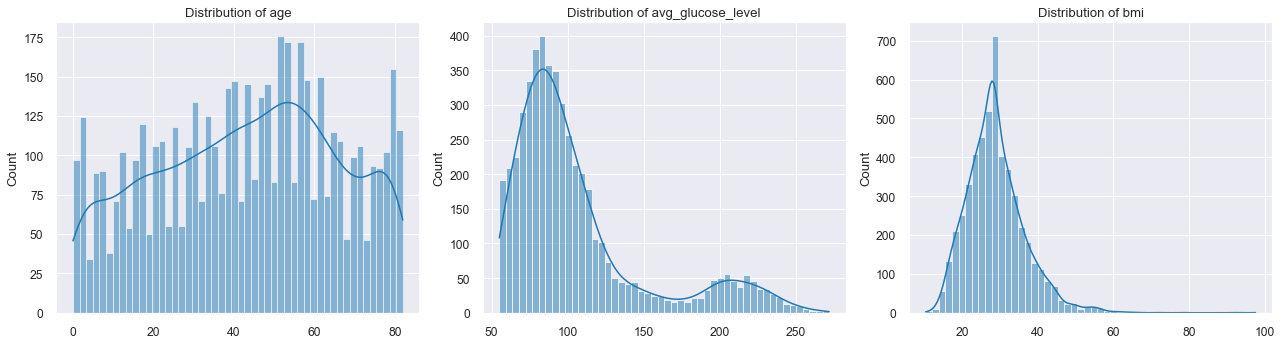

In [13]:
fig = plt.figure(1, (18, 5))

for i, feature in enumerate(num_features):
    ax = plt.subplot(1, 3, i+1)
    # sns.displot(data=df_nums, x=feature, kde=True)
    sns.histplot(data=df_nums, x=feature, kde=True, bins=50)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()

- Already checked in EDA previously. Only `age` is similar to normal distribution.

<br>

A **log-normal distribution** is a distribution of a random variable whose logarithm is normally distributed.

Checking whether these features are log-normal or not.

In [14]:
df_log = np.log2(df_nums)
df_log.head()

,age,avg_glucose_level,bmi
0,6.066089,7.837249,5.193772
1,5.930737,7.659711,4.812498
2,6.321928,6.726831,5.022368
3,5.614710,7.419792,5.104337
4,6.303781,7.443938,4.584963


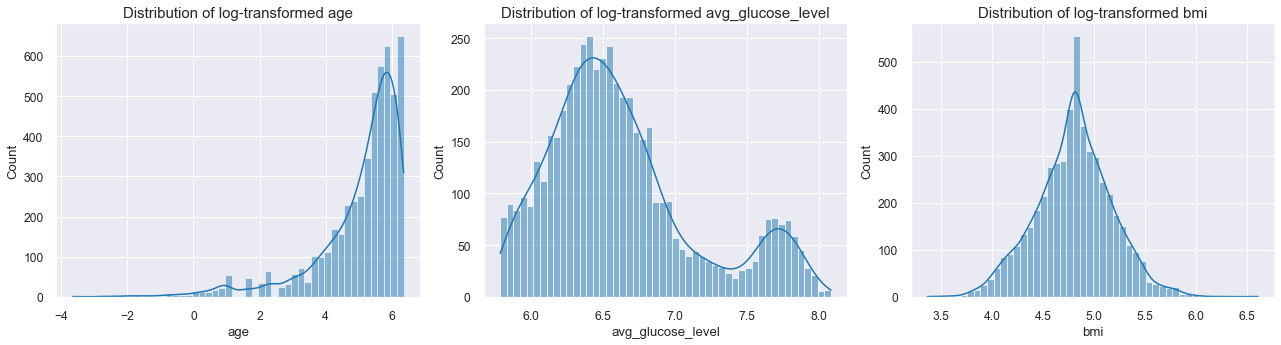

In [15]:
fig = plt.figure(1, (18, 5))

for i, num_feature in enumerate(num_features):
    ax = plt.subplot(1, 3, i+1)
    ax.set_title(f'Distribution of log-transformed {num_feature}', size=15)
    sns.histplot(data=df_log, x=num_feature, kde=True, bins=50)
    plt.tight_layout()
plt.show()

- After log transformation, `age` has become significantly left-skewed, `avg_glucose_level` is not log-normal too.
- Only `bmi` has become visually very similar to a log-normal distribution, note that the higher peak in the middle is likely due to the median imputation for the missing values.

**Using quantile-quantile plot (Q-Q Plot) to visualize their normality**

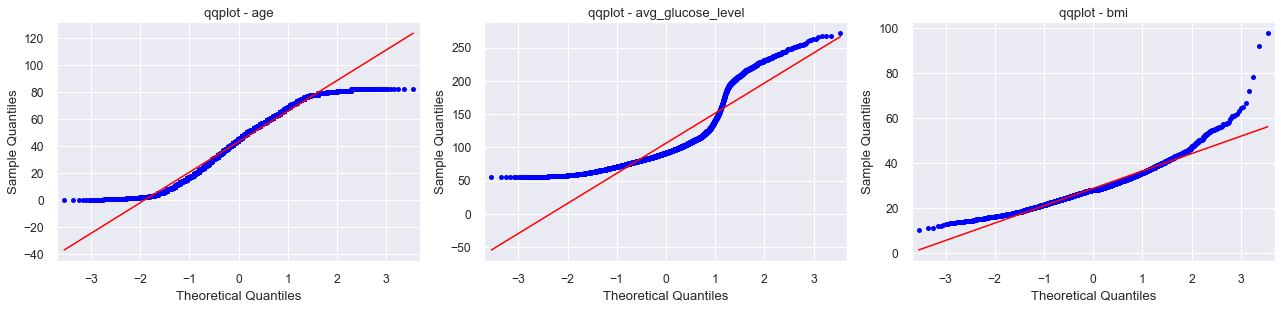

In [16]:
from statsmodels.graphics.gofplots import qqplot
# quantile-quantile plots on original data
fig = plt.figure(1, (18, 8))

for i, num_feature in enumerate(df_nums):
    ax = plt.subplot(2, 3, i+1)
    qqplot(df_nums[num_feature], line='s', ax=ax, markersize=5)
    ax.set_title(f'qqplot - {num_feature}')
    plt.tight_layout()
plt.show()

By looking at whether the points fall on the expected best fit line (red line, mean=0, std=1), normality can be determined. <br>
- `age` is half-way to become a normal distribution, with less data at extreme values (points at left side are above the expected best line, points at right side are below)
- `bmi` also generally seems to be normal distribution, but with some exceptions at extreme values.

## Hypothesis Tests for Normality

In [17]:
from scipy import stats
# let's contruct a function
def shapiro_wilk_test(df, cols, alpha=0.05):
    # test the null hypothesis for columns given in `cols` of the dataframe `df` under significance level `alpha`.
    for col in cols:
        w, p = stats.shapiro(df[col])
        if p <= alpha:
            print(f"Rejected H0 under significance level {alpha}")
            print(f"{col} differs significantly from a normal distribution (W={w:.3f}, p={p:.5f})\n")
        else:
            print(f"\nFail to reject H0 due to lack of evidence under significance level {alpha}\n")
            print(f"{col} seem to be normally distributed (W={w:.3f}, p={p:.5f})")

In [18]:
shapiro_wilk_test(df_nums, num_features)

Rejected H0 under significance level 0.05
age differs significantly from a normal distribution (W=0.967, p=0.00000)

Rejected H0 under significance level 0.05
avg_glucose_level differs significantly from a normal distribution (W=0.806, p=0.00000)

Rejected H0 under significance level 0.05
bmi differs significantly from a normal distribution (W=0.951, p=0.00000)



C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


- Shapiro-Wilk Test has a problem for detecting normality when the sample size is large (>5000), which is typical for most tests

- Trying to apply `power transform` to make the data more Gaussian-like (normal-like). Default method is `Yeo-Johnson` transform.

In [19]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
transformed_df = pt.fit_transform(df_nums)
transformed_df = pd.DataFrame(transformed_df, columns=df_nums.columns)
transformed_df.head()

,age,avg_glucose_level,bmi
0,1.032769,1.862392,1.045197
1,0.788093,1.700511,0.026753
2,1.552975,0.395031,0.587449
3,0.288329,1.445120,0.806387
4,1.513397,1.472918,-0.580998


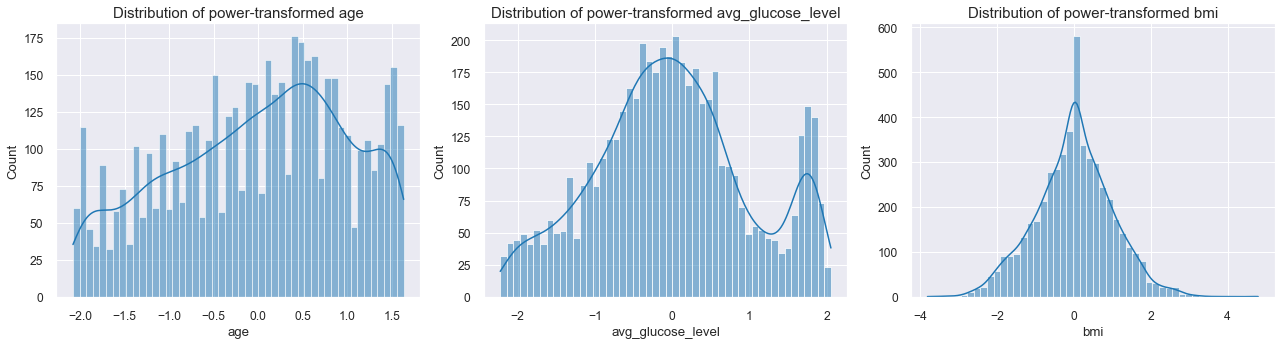

In [20]:
fig = plt.figure(1, (18, 5))

for i, num_feature in enumerate(num_features):
    ax = plt.subplot(1, 3, i+1)
    ax.set_title(f'Distribution of power-transformed {num_feature}', size=15)
    sns.histplot(data=transformed_df, x=num_feature, kde=True, bins=50)
    plt.tight_layout()
plt.show()

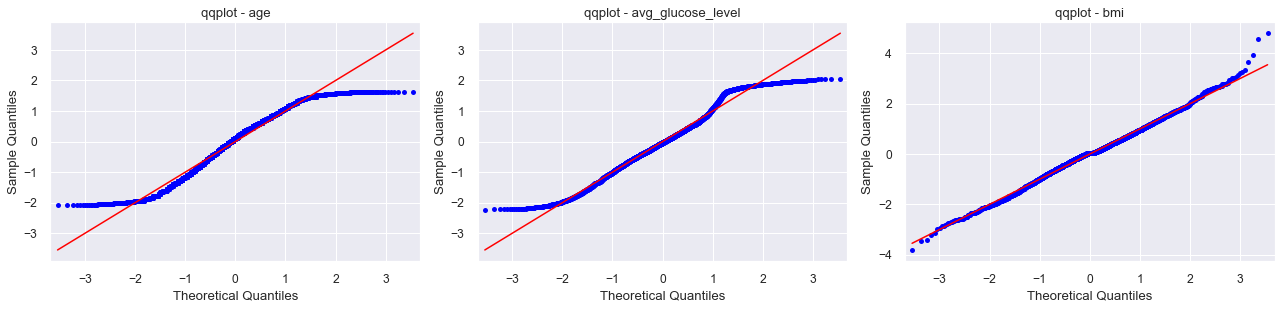

In [21]:
fig = plt.figure(1, (18,8))

for i, num_feature in enumerate(df_nums):
    ax = plt.subplot(2,3,i+1)
    qqplot(transformed_df[num_feature], line='s', ax=ax, markersize=5)
    ax.set_title(f'qqplot - {num_feature}')
    plt.tight_layout()
plt.show()

- `age` is similar to before transformation, while `avg_glucose_level` has become more normal-like but still far from ideal.
- `bmi` has become almost entirely normal distribution after the power transformation.

In [22]:
shapiro_wilk_test(transformed_df, num_features)

Rejected H0 under significance level 0.05
age differs significantly from a normal distribution (W=0.965, p=0.00000)

Rejected H0 under significance level 0.05
avg_glucose_level differs significantly from a normal distribution (W=0.981, p=0.00000)

Rejected H0 under significance level 0.05
bmi differs significantly from a normal distribution (W=0.996, p=0.00000)



C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


- Even after transforming, all of them are still deemed significantly different from normal distribution through the Shapiro-Wilk Test, <br> 
this is most likely due to the limitation of the test.
- However, visually, it is evident to tell that `age` and `bmi` can be considered normal distribution, while `avg_glucose_level` is close to normal distribution after power transformation.
- Therefore, hypothesis tests of `t-test` or `ANOVA` can still be conducted.


- Generally, Shapiro-Wilk Test is not a good way to determine whether they are Gaussian "enough" to conduct such parametric hypothesis tests. 
- Quantile-quantile plot visualization is better for this.

## Hypothesis Test for Correlation

**Hypothesis definition** <br>
Null hypothesis, $H_0$ : Variable A and Variable B are **uncorrelated** <br>
Alternative hypothesis, $H_1$ : Variable A and Variable B are **correlated** <br>
 <br>
Significance level, $\alpha$ is generally set to 0.05. <br>

- p-value $\le$  $\alpha$ : significant result, reject null hypothesis.
- p-value $\gt$  $\alpha$ : not significant result, fail to reject null hypothesis. <br><br>
- To analyze whether there is a significant association between two numerical features, **Pearson's/Spearman's correlation** are commonly used. <br>
- Such methods are for statistical hypothesis test, therefore they assume that the samples are uncorrelated (fail to reject $H_0$).

**Assumptions of pearson correlation**:
1. Both variables should have a Gaussian or Gaussian-like distribution.
2. Relationship between the variables should be linear.
3. Homoscedasticity i.e., a sequence of random variables where all its random variables have the same finite variance.

Also Pearson is quite sensitive to outliers. So in this case, Spearman's correlation is preferred since there are many outliers for `avg_glucose_level` and `bmi`.

In [23]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from itertools import combinations

list(combinations(num_features, 2))

[('age', 'avg_glucose_level'), ('age', 'bmi'), ('avg_glucose_level', 'bmi')]

In [25]:
def test_correlation(x1, x2, method='spearman', alpha=ALPHA):
    # this function returns correlation, p-value and H0 for `x1` & `x2`
    
    ALLOWED_METHODS = ['pearson', 'spearman', 'kendall']
    if method not in ALLOWED_METHODS:
        raise ValueError(f'Allowed methods are {ALLOWED_METHODS}')
        
    if method =='pearson':
        corr, p = pearsonr(x1, x2)
    elif method =='spearman':
        corr, p = spearmanr(x1, x2)
    else:
        corr, p = kendalltau(x1, x2)
    
    h0 = 'Rejected' if p <= alpha else 'Fail to reject'
    
    return corr, p, h0

In [48]:
df_corr = pd.DataFrame(columns=['feature_1', 'feature_2', 'correlation', 'p', 'H0'])

for x, y in combinations(num_features, r=2):
    corr, p, h0 = test_correlation(df_nums[x], df_nums[y])
    
    df_corr = df_corr.append({'feature_1': x, 'feature_2': y,
                              'correlation': round(corr, 5), 'p': p, 'H0': h0}, ignore_index=True)
    
df_corr.style.highlight_max(color='navy')

,feature_1,feature_2,correlation,p,H0
0,age,avg_glucose_level,0.145360,0.000000,Rejected
1,age,bmi,0.362650,0.000000,Rejected
2,avg_glucose_level,bmi,0.112170,0.000000,Rejected


- All of their null hypothesis are rejected, therefore all of the numerical features are correlated to each other. 
- With `age` and `bmi` being moderately more correlated than the other 2 combinations

# Statistical Significance Tests

**Parametric Statistical Significance Tests** <br>
1. **Student’s t-test** - It tests whether the two independent normal distributed samples have the same mean or not. <br>
2. **Analysis of Variance test (ANOVA)** - It tests whether the two or more independent normal distributed samples have the same mean or not. <br>
ANOVA serves the same purpose with t-test but for more than two variables instead of only two variables. So either apply t-test pair-wise or apply ANOVA once.  <br>
ANOVA also only tells whether all the samples have the same mean or not, it doesn't quantify which samples differ or by how much.

**Non-Parametric Statistical Significance Tests** <br>
1. **Mann-Whitney U test** - Non-parametric equivalent of **Student's t-test**. <br>
2. **Kruskal-Wallis H test** - Non-parametric equivalent of **ANOVA** (but it compares the median instead). <br>

Parametric tests are for normally distributed data, while non-parametric tests are for non-normally distributed data. <br>
However, in this case, the Shapiro-Wilk test is not a good way for determine whether they are normally distributed or not. <br>
We have already verified that the 3 numerical features `age`, `avg_glucose_level` and `bmi` are similar to normal distribution in the Q-Q plots. <br>
Therefore, it is generally good enough to apply parametric tests by inspecting the visualizations.

In [27]:
num_features

['age', 'avg_glucose_level', 'bmi']

In [28]:
print(cat_features)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_range', 'hypertension', 'heart_disease', 'stroke']


## t-tests

In [29]:
from scipy import stats

In [30]:
x, y = df[df.gender=='Male'].age, df[df.gender=='Female'].age

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different Age distributions between Male and Female (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same Age distributions between Male and Female (t={t}, p={p}).')

Since p = 0.0499 < 0.05, reject H0, different Age distributions between Male and Female (t=-1.96135, p=0.0499)


- The p-value is 0.0499 which is ***very close*** to **fail to reject H0**, therefore they can actually be considered as borderline similar distribution.

In [31]:
x, y = df[df.gender=='Male'].avg_glucose_level, df[df.gender=='Female'].avg_glucose_level

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different avg_glucose_level distributions between Male and Female (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same avg_glucose_level distributions between Male and Female (t={t}, p={p}).')

Since p = 0.00012 < 0.05, reject H0, different avg_glucose_level distributions between Male and Female (t=3.86007, p=0.00012)


In [32]:
x, y = df[df.gender=='Male'].bmi, df[df.gender=='Female'].bmi

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different BMI distributions between Male and Female (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same BMI distributions between Male and Female (t={t}, p={p}).')

Since p = 0.05478 > 0.05, fail to reject H0, same BMI distributions between Male and Female (t=-1.92107, p=0.05478).


In [33]:
x, y = df[df.stroke==1].age, df[df.stroke==0].age

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different Age distributions between Stroke and "No stroke" (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same Age distributions between Stroke and "No stroke" (t={t}, p={p}).')

Since p = 0.0 < 0.05, reject H0, different Age distributions between Stroke and "No stroke" (t=29.68186, p=0.0)


In [34]:
x, y = df[df.stroke==1].avg_glucose_level, df[df.stroke==0].avg_glucose_level

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different avg_glucose_level distributions between Stroke and "No stroke" (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same avg_glucose_level distributions between Stroke and "No stroke" (t={t}, p={p}).')

Since p = 0.0 < 0.05, reject H0, different avg_glucose_level distributions between Stroke and "No stroke" (t=6.98438, p=0.0)


In [35]:
x, y = df[df.stroke==1].bmi, df[df.stroke==0].bmi

t, p = stats.ttest_ind(x, y, equal_var=False)
t, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different BMI distributions between Stroke and "No stroke" (t={t}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same BMI distributions between Stroke and "No stroke" (t={t}, p={p}).')

Since p = 0.00099 < 0.05, reject H0, different BMI distributions between Stroke and "No stroke" (t=3.32566, p=0.00099)


### Summary Tables for t-test Results

In [71]:
t_test_df = pd.DataFrame(columns=['cat_feat', 'num_feat', 'alpha', 't', 'p'])

for feature in num_features:
    t, p = stats.ttest_ind(df.loc[df.gender=='Male', feature],
                            df.loc[df.gender=='Female', feature],
                            equal_var=False)
    t, p = round(t, 3), round(p, 5)
    t_test_df = t_test_df.append({'cat_feat': 'gender', 'num_feat': feature,
                    'alpha': ALPHA, 't': t, 'p': p}, ignore_index=True)

t_test_df['H0'] = t_test_df.p.apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')
t_test_df['relation'] = t_test_df.H0.apply(lambda x: 'Different' if x =='Rejected' else 'Same')

def color_fail_to_rej(value):
    if value in ('Fail to reject', 'Same'):
        return 'color:green'
    else:
        return 'cmap: Blues'
    
t_test_df.style.background_gradient(cmap = 'Blues').applymap(color_fail_to_rej)

,cat_feat,num_feat,alpha,t,p,H0,relation
0,gender,age,0.050000,-1.961000,0.049900,Rejected,Different
1,gender,avg_glucose_level,0.050000,3.860000,0.000120,Rejected,Different
2,gender,bmi,0.050000,-1.921000,0.054780,Fail to reject,Same


In [64]:
t_test_df = pd.DataFrame(columns=['cat_feat', 'num_feat', 'alpha', 't', 'p'])

for feature in num_features:
    t, p = stats.ttest_ind(df.loc[df.stroke==0, feature],
                            df.loc[df.stroke==1, feature],
                            equal_var=False)
    t, p = round(t, 3), round(p, 5)
    t_test_df = t_test_df.append({'cat_feat': 'stroke', 'num_feat': feature,
                    'alpha': ALPHA, 't': t, 'p': p}, ignore_index=True)

t_test_df['H0'] = t_test_df.p.apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')
t_test_df['relation'] = t_test_df.H0.apply(lambda x: 'Different' if x =='Rejected' else 'Same')
t_test_df.style.style.background_gradient(cmap = 'Blues').applymap(color_fail_to_rej)

,cat_feat,num_feat,alpha,t,p,H0,relation
0,stroke,age,0.050000,-29.682000,0.000000,Rejected,Different
1,stroke,avg_glucose_level,0.050000,-6.984000,0.000000,Rejected,Different
2,stroke,bmi,0.050000,-3.326000,0.000990,Rejected,Different


## One-way ANOVA tests

In [38]:
smoking_age_group = df.groupby('smoking_status')['age'].unique()
smoking_age_group

smoking_status
Unknown            [59.0, 78.0, 57.0, 82.0, 58.0, 42.0, 75.0, 76....
formerly smoked    [67.0, 81.0, 71.0, 65.0, 59.0, 80.0, 82.0, 74....
never smoked       [61.0, 80.0, 79.0, 74.0, 69.0, 81.0, 50.0, 60....
smokes             [49.0, 61.0, 54.0, 64.0, 75.0, 71.0, 69.0, 57....
Name: age, dtype: object

In [39]:
f_statistic, p = stats.f_oneway(*smoking_age_group)
f_statistic, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different Age distributions among different smoking_status (F={f_statistic}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same Age distributions among different smoking_status (F={f_statistic}, p={p}).')

Since p = 3e-05 < 0.05, reject H0, different Age distributions among different smoking_status (F=-3.326, p=3e-05)


In [40]:
bmi_range_group = df.groupby('bmi_range')['age'].unique()
f_statistic, p = stats.f_oneway(*bmi_range_group)
f_statistic, p = round(t, 5), round(p, 5)

if p <= ALPHA:
    print(f'Since p = {p} < {ALPHA}, reject H0, different Age distributions among different bmi_range (F={f_statistic}, p={p})')
else:
    print(f'Since p = {p} > {ALPHA}, fail to reject H0, same Age distributions among different bmi_range (F={f_statistic}, p={p}).')

Since p = 0.0 < 0.05, reject H0, different Age distributions among different bmi_range (F=-3.326, p=0.0)


**Conclusion**

- For the important parts, only `Male` and `Female` has similar distribution in terms of the mean values of `age` and `bmi`.
- With respect to `stroke`, all the numerical features have different distributions.

# Summary of Relationship between Categorical and Numerical Features

In [41]:
from sklearn import feature_selection

In [65]:
f, p = feature_selection.f_classif(df.loc[:, 'age': 'bmi'], df.gender)
f, p = np.around(f, 3), np.around(p, 5)
anova_test_cat = pd.DataFrame({
    'cat-attr': 'gender',
    'cont-attr': df.loc[:, 'age': 'bmi'].columns,
    'f': f, 
    'p': p,
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'Different' if x =='Rejected' else 'Same')
anova_test_cat.style.background_gradient(cmap = 'Blues').applymap(color_fail_to_rej)

,cat-attr,cont-attr,f,p,alpha,H0,relation
0,gender,age,3.936000,0.047310,0.050000,Rejected,Different
1,gender,avg_glucose_level,15.339000,0.000090,0.050000,Rejected,Different
2,gender,bmi,3.576000,0.058680,0.050000,Fail to reject,Same


In [66]:
f, p = feature_selection.f_classif(df.loc[:, 'age': 'bmi'], df.stroke)
f, p = np.around(f, 3), np.around(p, 5)
anova_test_cat = pd.DataFrame({
    'cat-attr': 'stroke',
    'cont-attr': df.loc[:, 'age': 'bmi'].columns,
    'f': f, 
    'p': p,
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'Different' if x =='Rejected' else 'Same')
anova_test_cat.style.background_gradient(cmap = 'Blues').applymap(color_fail_to_rej)

,cat-attr,cont-attr,f,p,alpha,H0,relation
0,stroke,age,326.800000,0.000000,0.050000,Rejected,Different
1,stroke,avg_glucose_level,90.550000,0.000000,0.050000,Rejected,Different
2,stroke,bmi,6.655000,0.009910,0.050000,Rejected,Different


**Conclusion**


- The ANOVA test results are the same with the t-test results, with little difference between the p-values.
- But it is summarized clearly in table forms here, where **only** the distributions of `gender` and `bmi` are the same.